From 
- https://github.com/facebookresearch/detr 
- https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/DETR_panoptic.ipynb#scrollTo=0Ys8lZhFCwXe

In [1]:
from PIL import Image
import requests
import io
import math
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
import numpy
torch.set_grad_enabled(False);

from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

import panopticapi
from panopticapi.utils import id2rgb, rgb2id

import itertools
import seaborn as sns

from copy import deepcopy

In [2]:
# These are the COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# Detectron2 uses a different numbering scheme, we build a conversion table
coco2d2 = {}
count = 0
for i, c in enumerate(CLASSES):
  if c != "N/A":
    coco2d2[i] = count
    count+=1

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [3]:
model, postprocessor = torch.hub.load('facebookresearch/detr', 'detr_resnet101_panoptic', pretrained=True, return_postprocessor=True, num_classes=250)
model.eval();

Using cache found in /Users/cr/.cache/torch/hub/facebookresearch_detr_main


In [18]:
url = "http://images.cocodataset.org/val2017/000000281759.jpg" # women & humbrellas
url = 'https://i.redd.it/5sbuolzhpd691.jpg' # hawc & coyote
url = 'https://i.redd.it/9eh6phbzw2t31.jpg' # bottles & glasses
im = Image.open(requests.get(url, stream=True).raw)

<class 'PIL.JpegImagePlugin.JpegImageFile'>


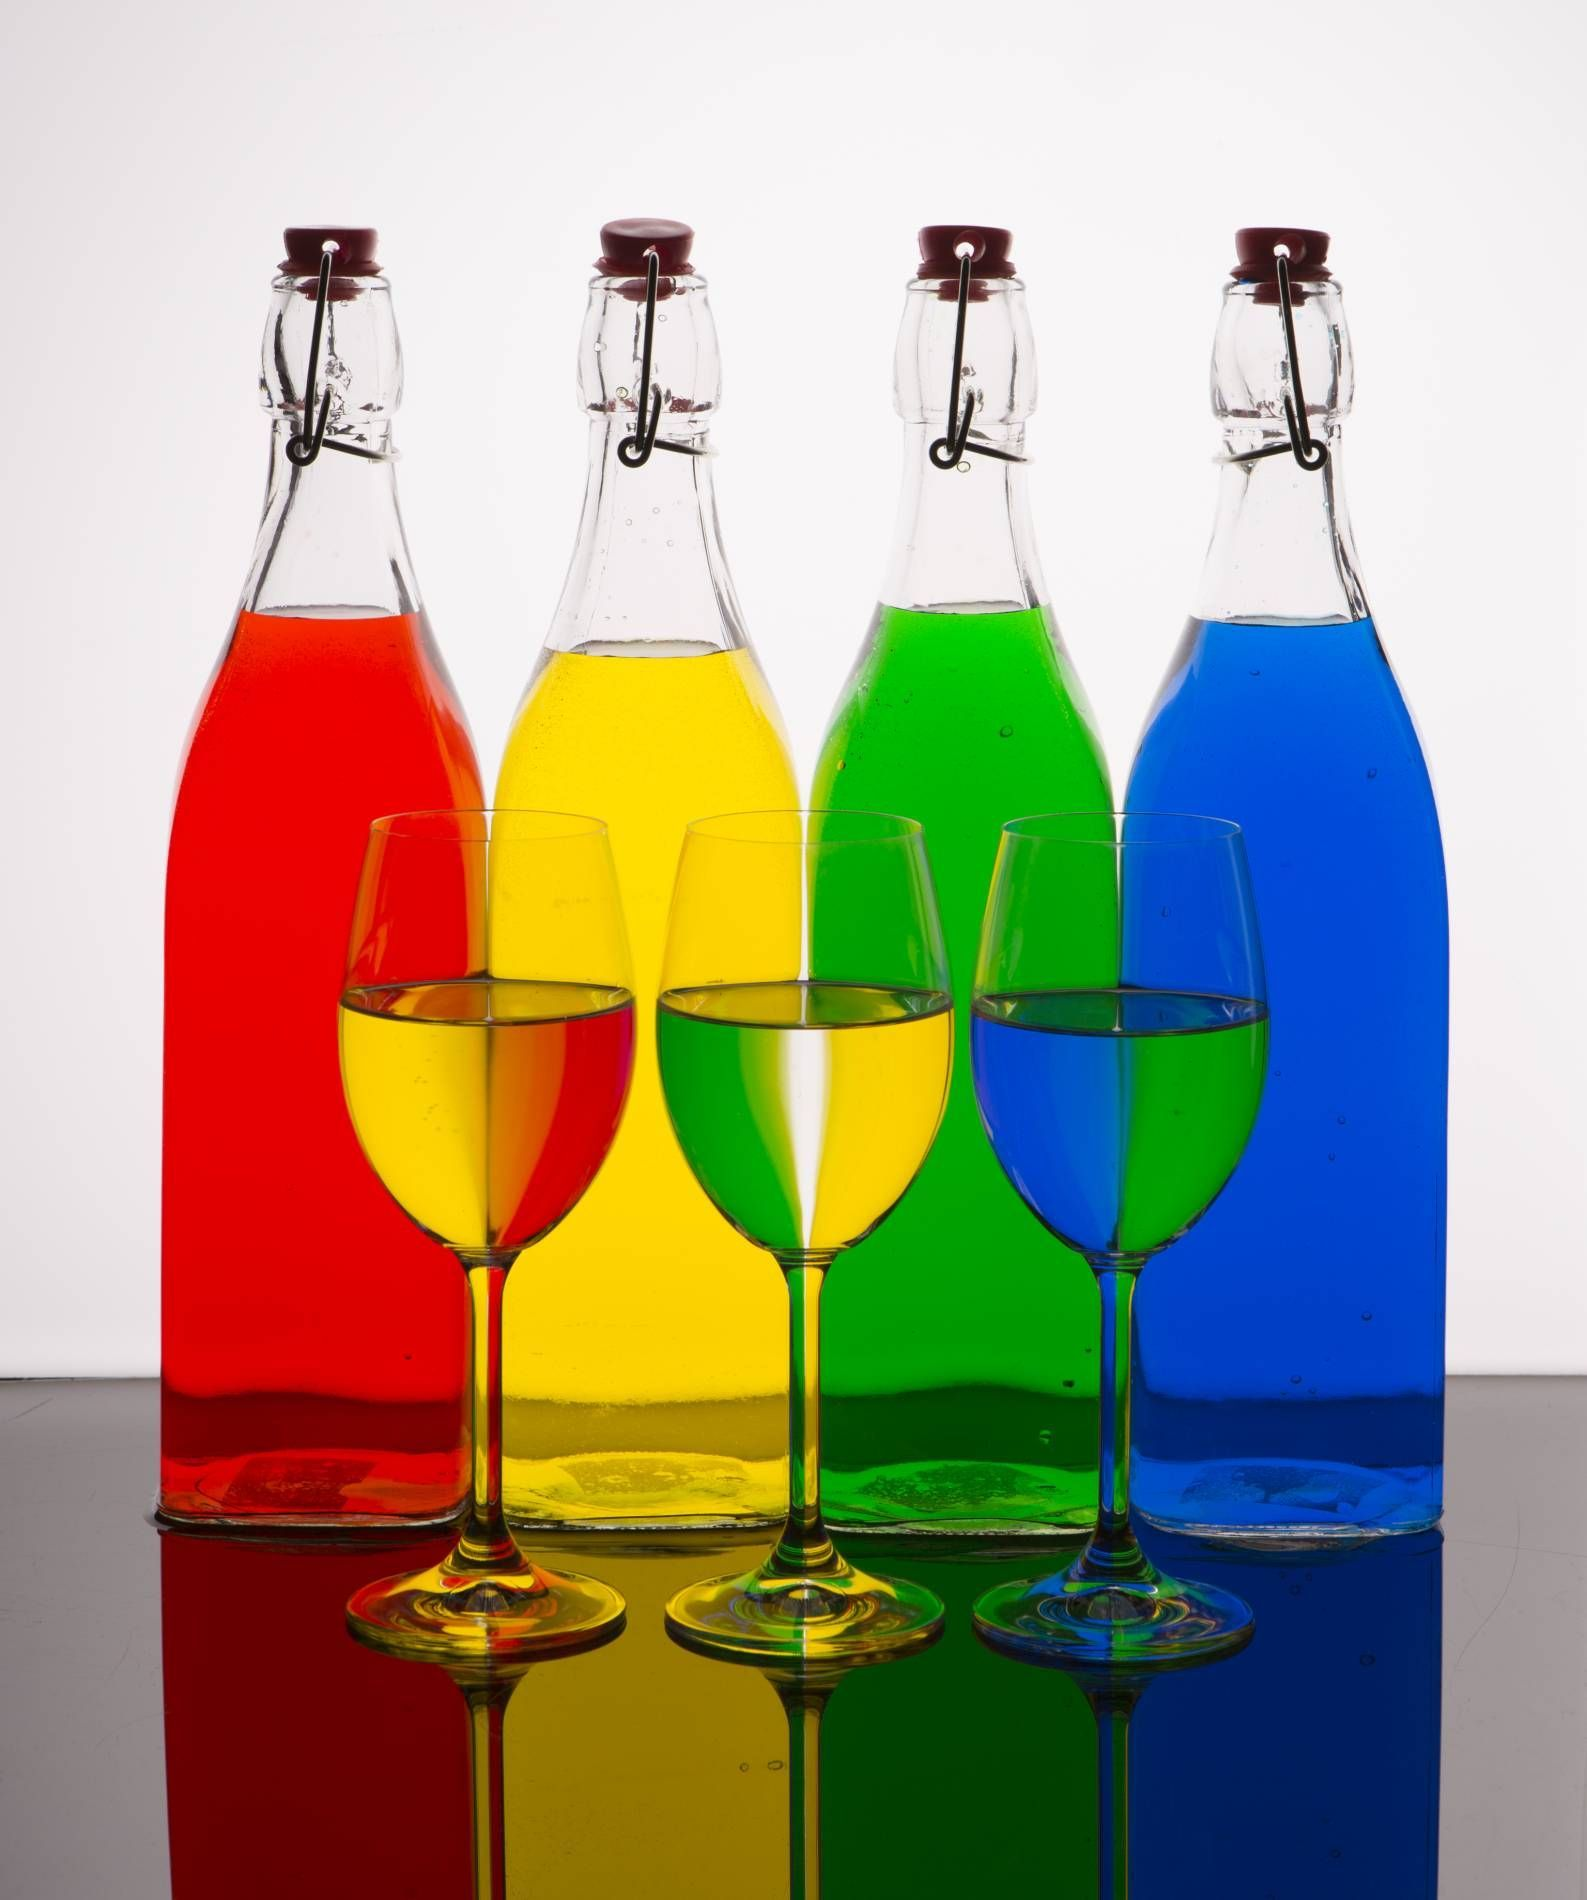

In [19]:
print(type(im))
im

In [20]:
# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)
out = model(img)

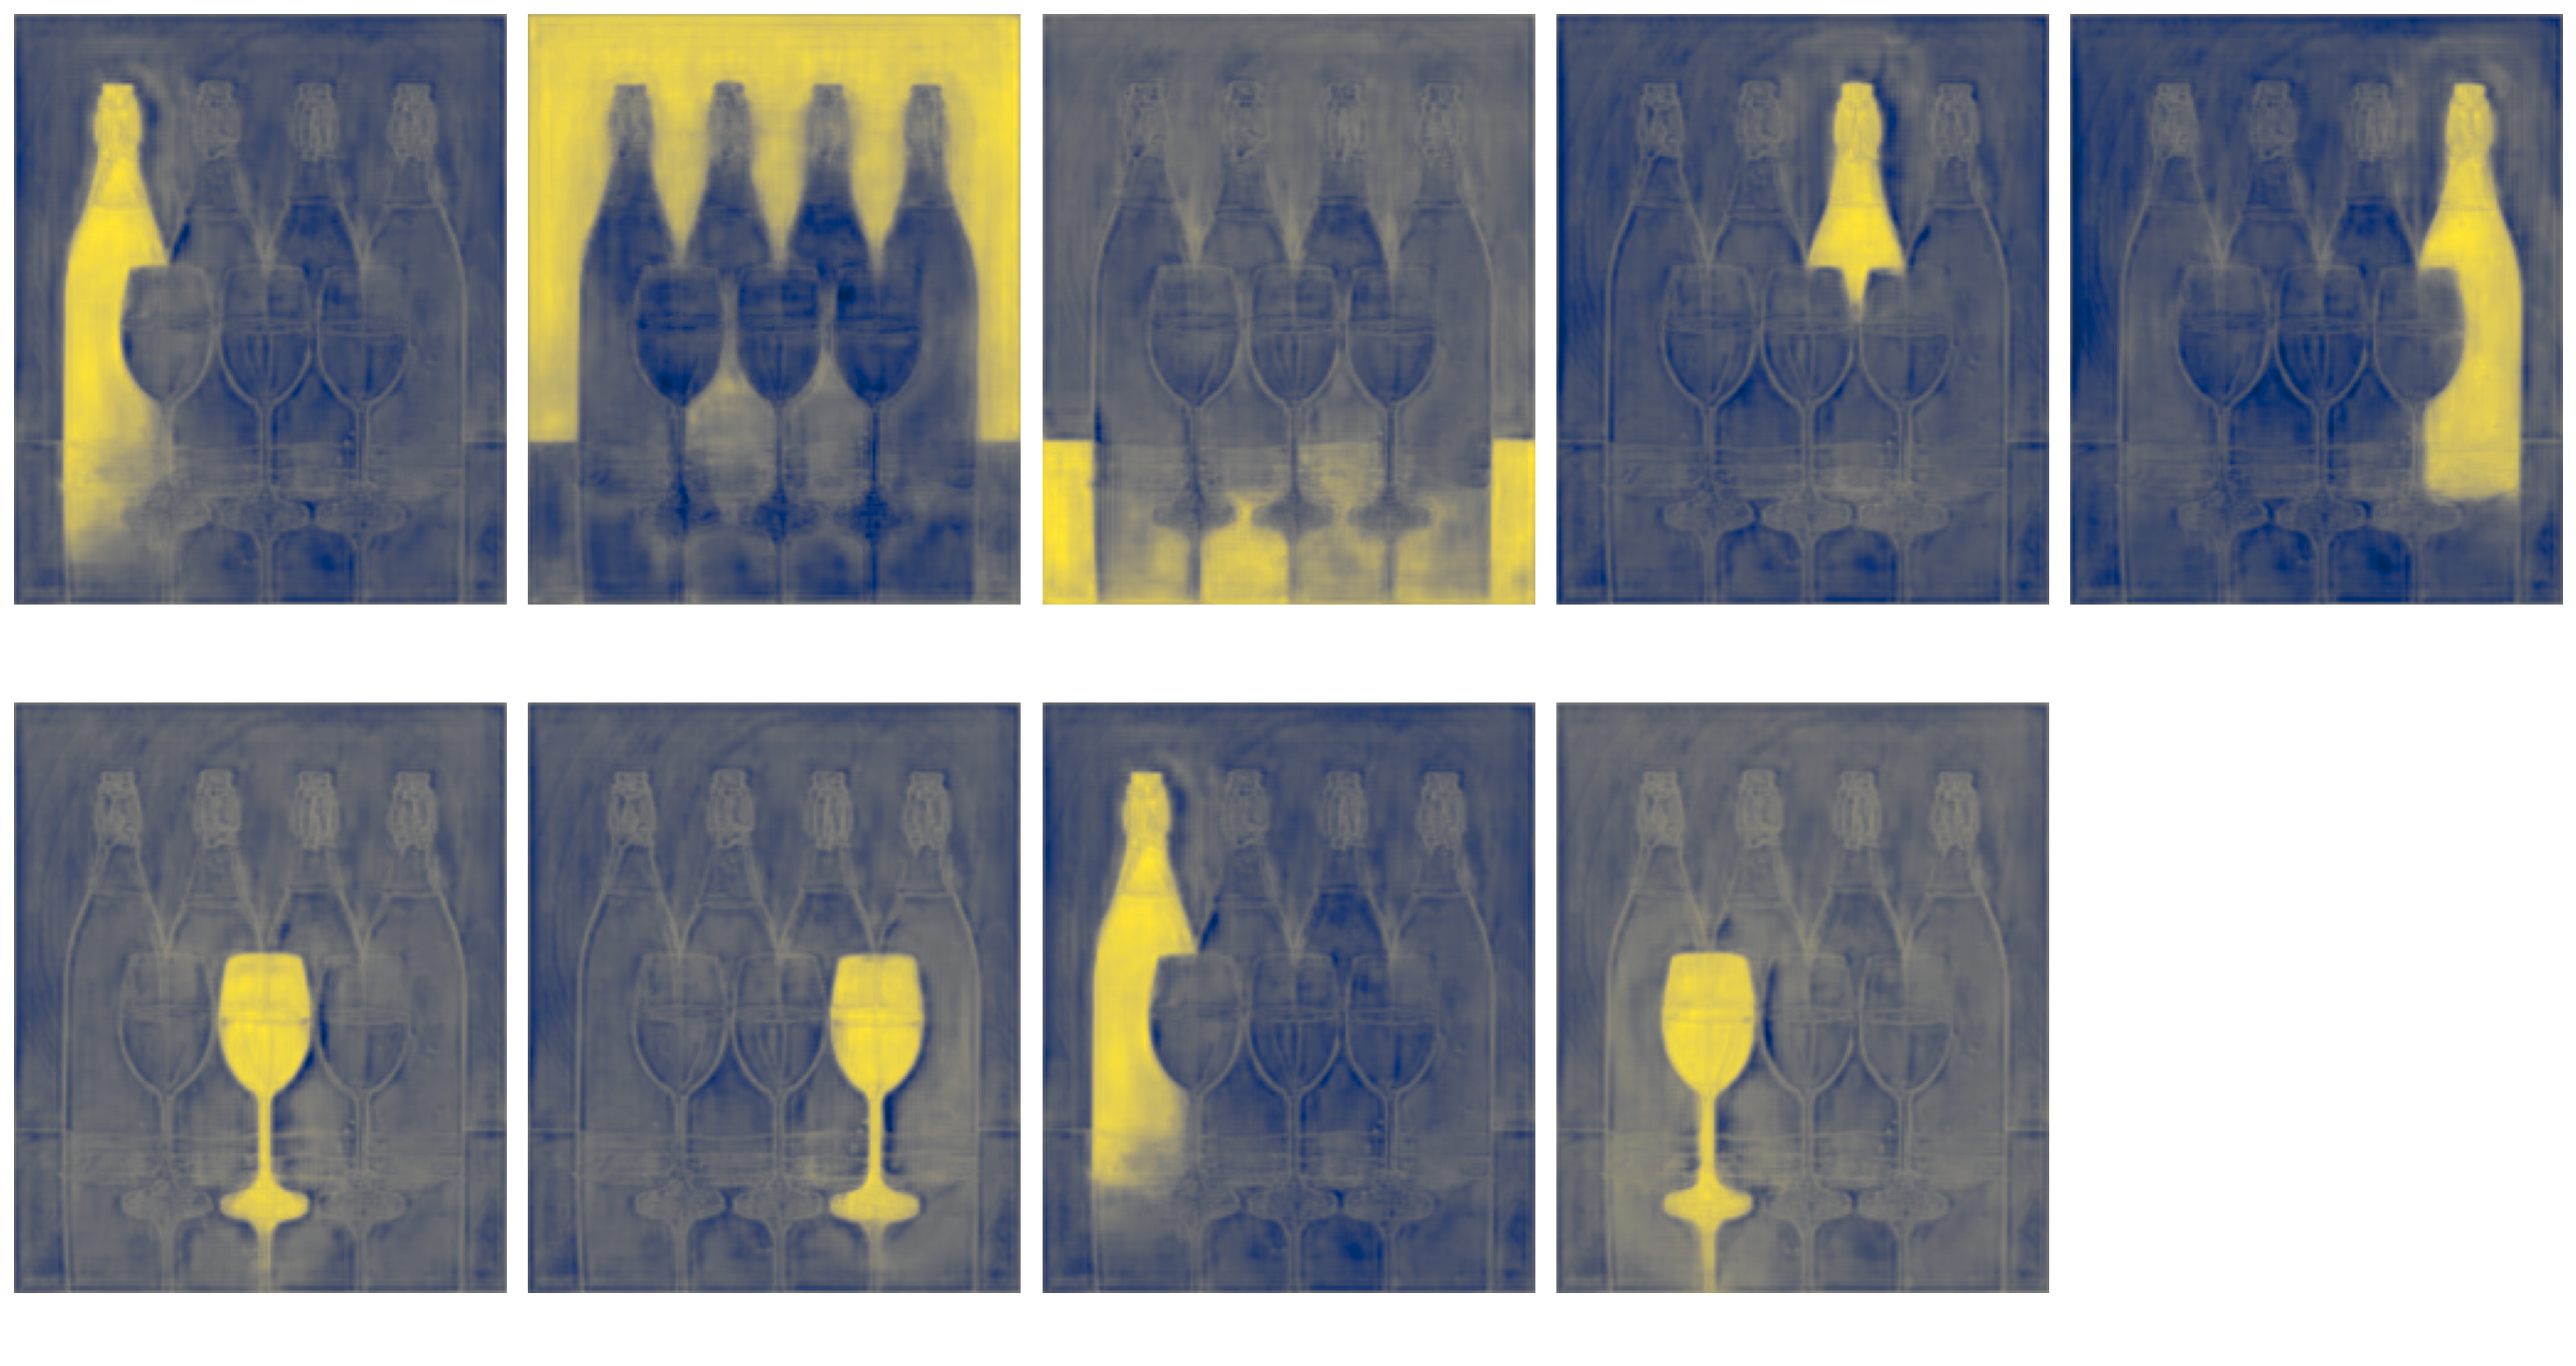

In [30]:
# compute the scores, excluding the "no-object" class (the last one)
scores = out["pred_logits"].softmax(-1)[..., :-1].max(-1)[0]
# threshold the confidence
keep = scores > 0.85

# Plot all the remaining masks
ncols = 5
fig, axs = plt.subplots(ncols=ncols, nrows=math.ceil(keep.sum().item() / ncols), figsize=(18, 10))
for line in axs:
    for a in line:
        a.axis('off')
for i, mask in enumerate(out["pred_masks"][keep]):
    ax = axs[i // ncols, i % ncols]
    ax.imshow(mask, cmap="cividis")
    ax.axis('off')
fig.tight_layout()

In [31]:
# the post-processor expects as input the target size of the predictions (which we set here to the image size)
result = postprocessor(out, torch.as_tensor(img.shape[-2:]).unsqueeze(0))[0]

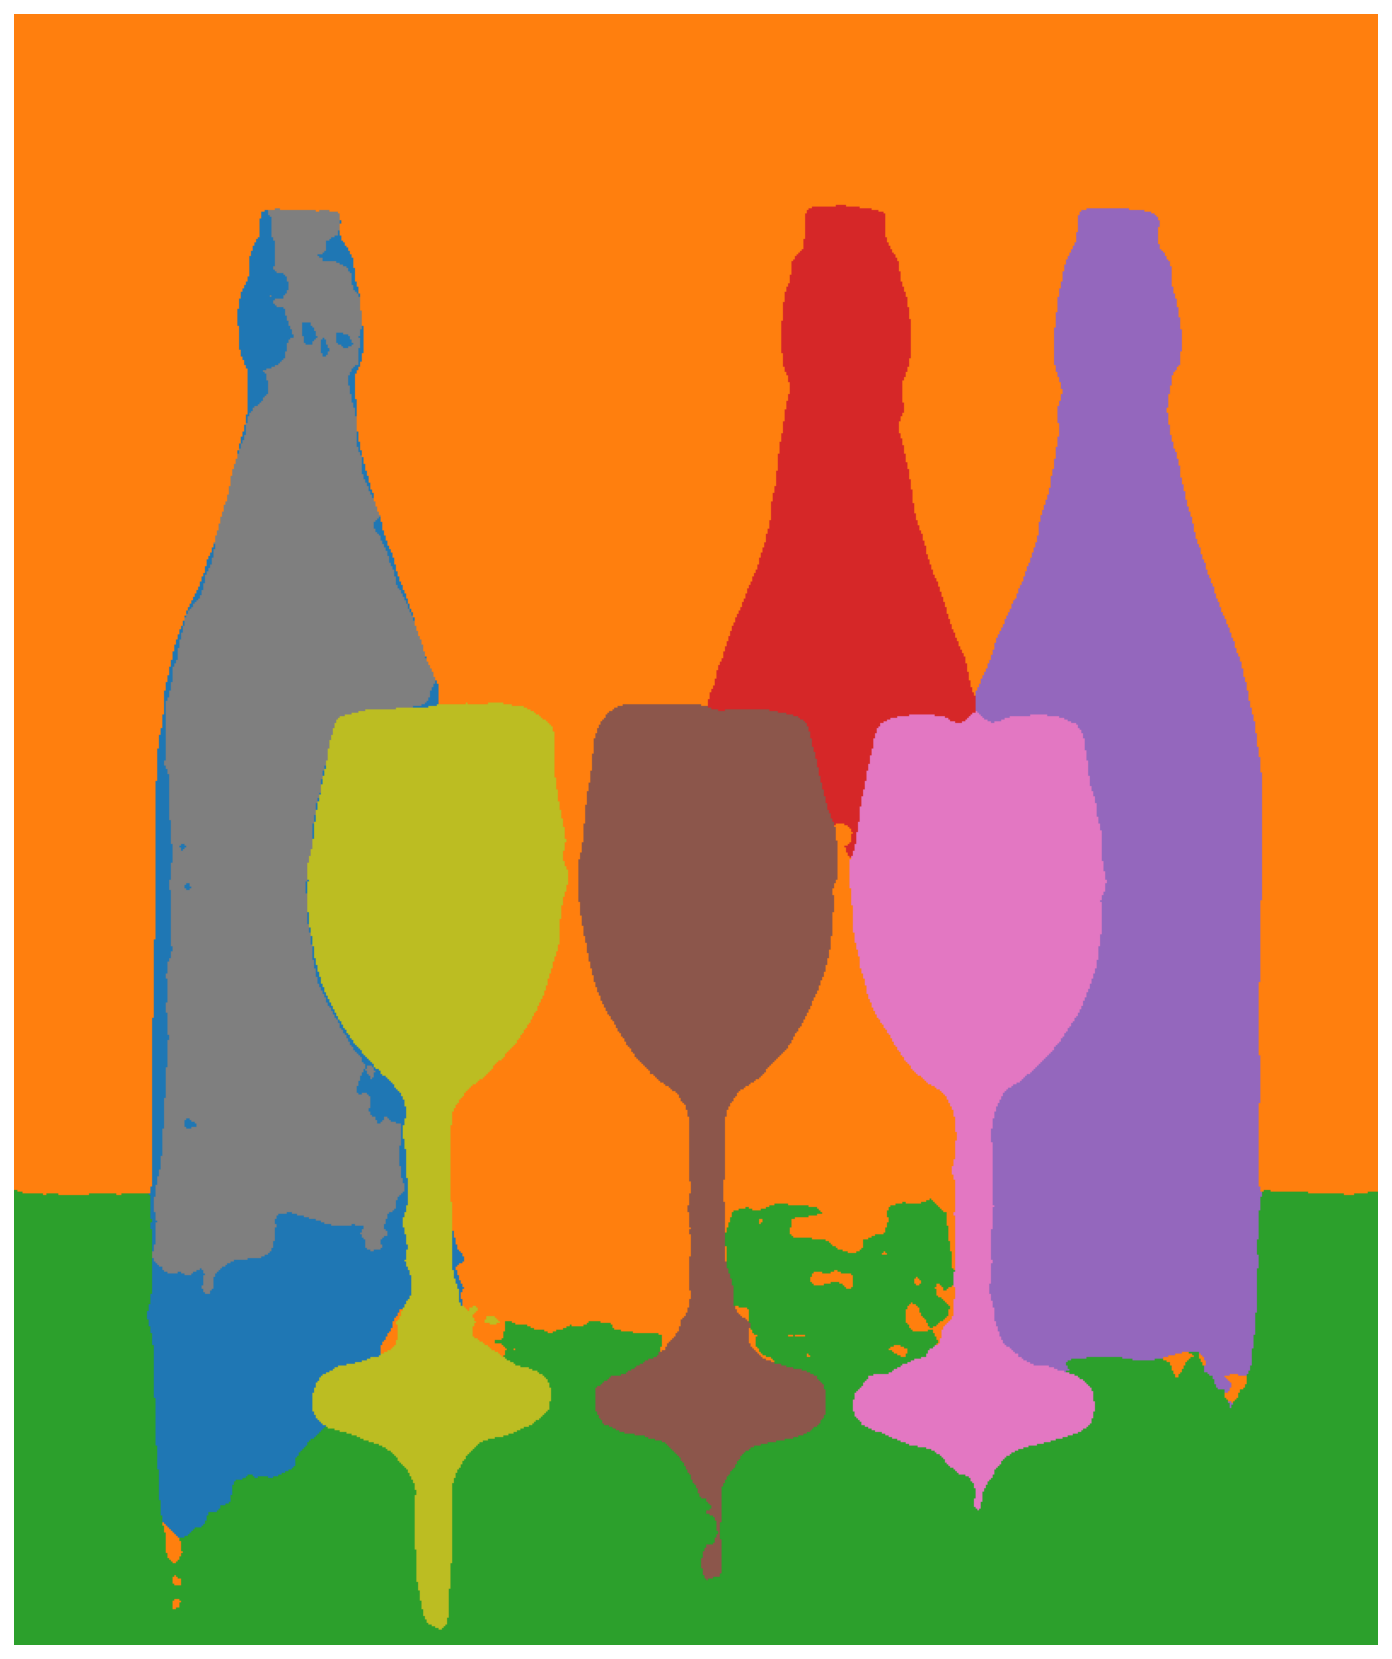

In [32]:
palette = itertools.cycle(sns.color_palette())

# The segmentation is stored in a special-format png
panoptic_seg = Image.open(io.BytesIO(result['png_string']))
panoptic_seg = numpy.array(panoptic_seg, dtype=numpy.uint8).copy()
# We retrieve the ids corresponding to each mask
panoptic_seg_id = rgb2id(panoptic_seg)

# Finally we color each mask individually
panoptic_seg[:, :, :] = 0
for id in range(panoptic_seg_id.max() + 1):
  panoptic_seg[panoptic_seg_id == id] = numpy.asarray(next(palette)) * 255
plt.figure(figsize=(15,15))
plt.imshow(panoptic_seg)
plt.axis('off')
plt.show()

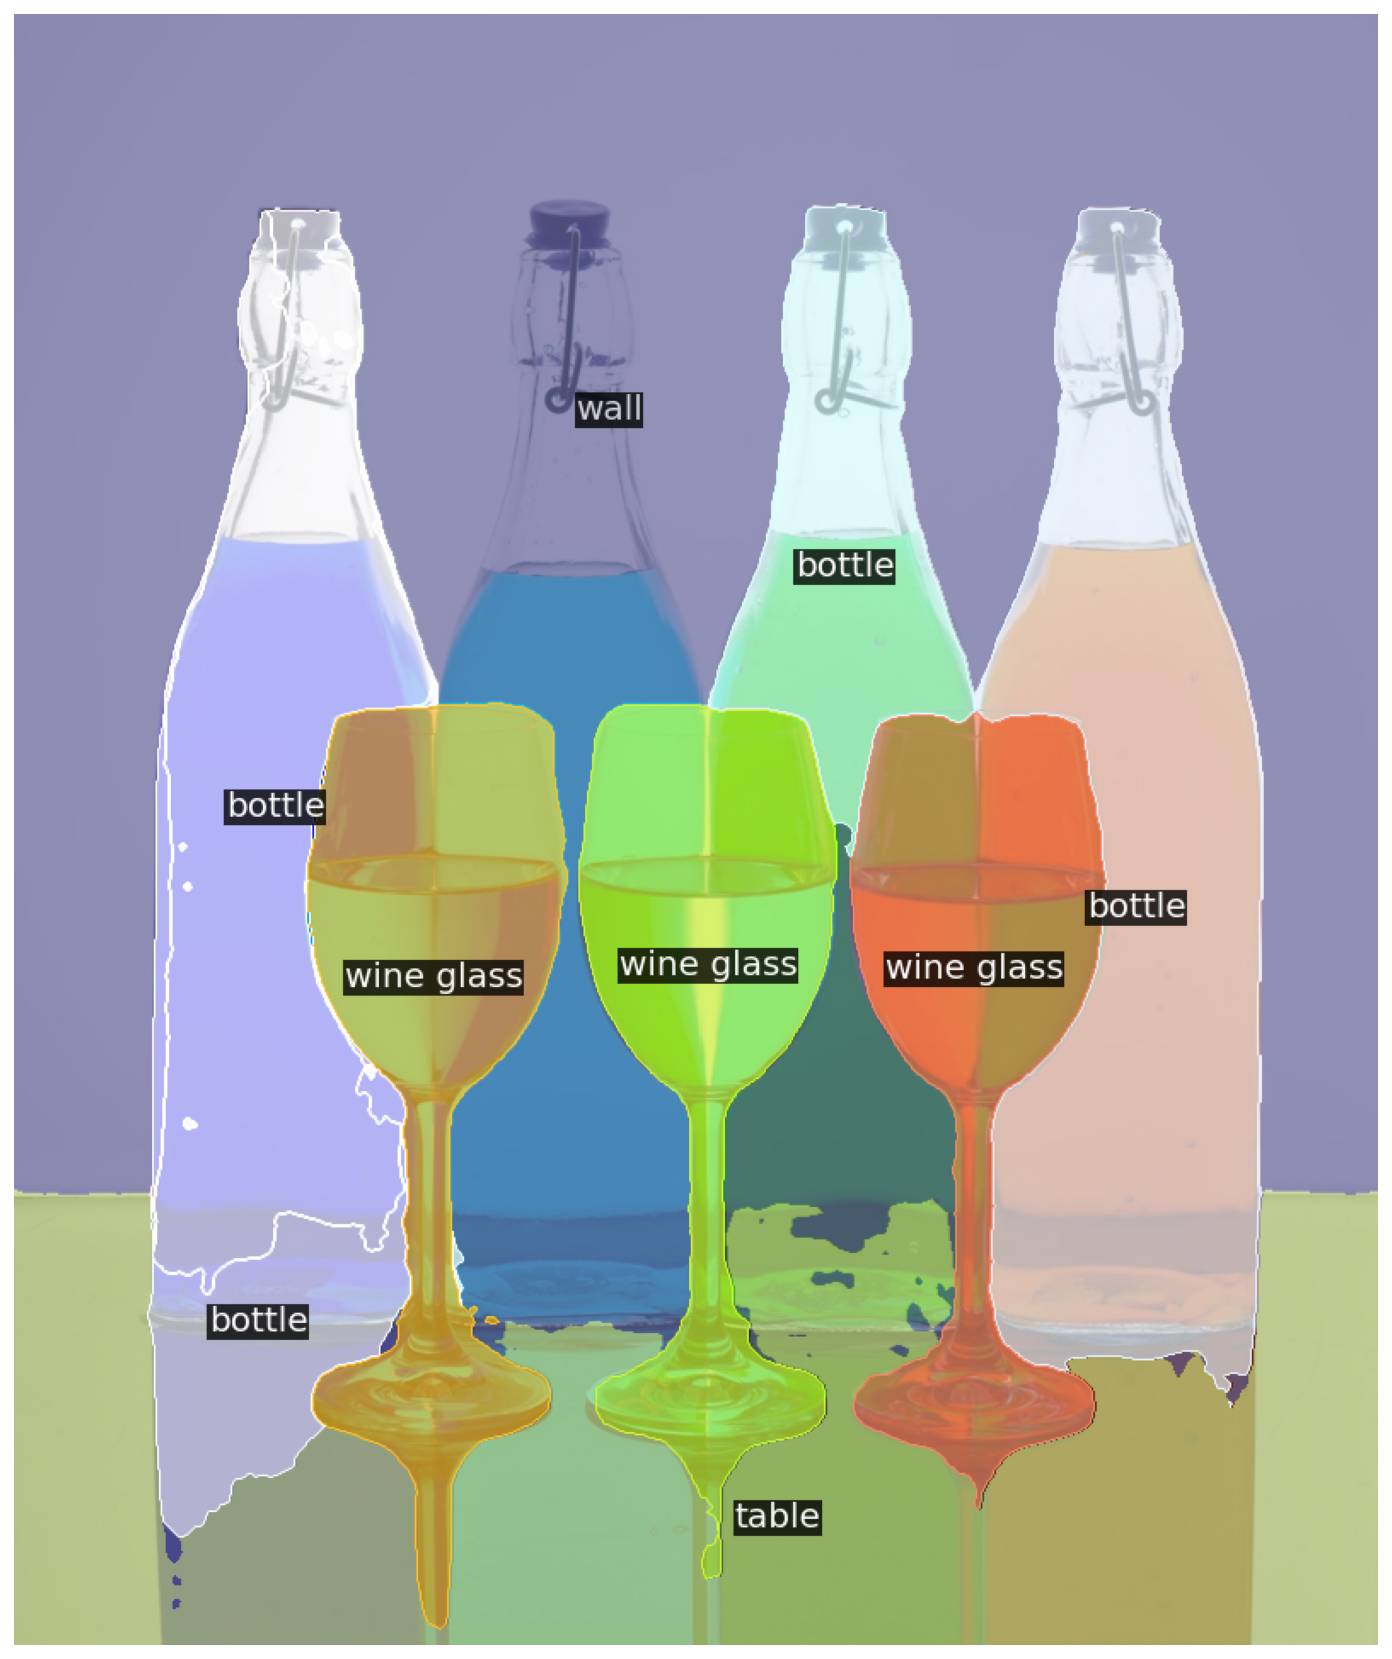

In [33]:
# We extract the segments info and the panoptic result from DETR's prediction
segments_info = deepcopy(result["segments_info"])
# Panoptic predictions are stored in a special format png
panoptic_seg = Image.open(io.BytesIO(result['png_string']))
final_w, final_h = panoptic_seg.size
# We convert the png into an segment id map
panoptic_seg = numpy.array(panoptic_seg, dtype=numpy.uint8)
panoptic_seg = torch.from_numpy(rgb2id(panoptic_seg))

    
    
# Detectron2 uses a different numbering of coco classes, here we convert the class ids accordingly
meta = MetadataCatalog.get("coco_2017_val_panoptic_separated")
for i in range(len(segments_info)):
    c = segments_info[i]["category_id"]
    segments_info[i]["category_id"] = meta.thing_dataset_id_to_contiguous_id[c] if segments_info[i]["isthing"] else meta.stuff_dataset_id_to_contiguous_id[c]


# Finally we visualize the prediction
v = Visualizer(numpy.array(im.copy().resize((final_w, final_h)))[:, :, ::-1], meta, scale=1.0)
v._default_font_size = 20
v = v.draw_panoptic_seg_predictions(panoptic_seg, segments_info, area_threshold=0)
plt.figure(figsize=(15,15))
plt.imshow(v.get_image())
plt.axis('off')
plt.show()